# Projet  de Python pour la data science
*Nathan VAN ASSCHE et Swann-Emilien MAILLEFERT*
Ce projet a pour but de proposer er un ensemble non exhaustif d'outils pour analyser l'inflation à partir de séries macroéconomiques provenant de l'Inse
Nous montrerons que l'outil simple de la régression OLS présente des failles importantes lorsque l'on cherche mesurer les effets de co-variables du fait de la non stationnarité des données considérées. Nous proposerons plusieurs méthodes pour prendre en compte cette non stationnarité.. 


## Récupération des données
Les données sont récupérées via l'API BDM de l'Insee en utilisant le package *pynsee*, cette opération nécessite l'initalisation d'une clé et d'un code de sécurité qui sont ensuite transmissibles à d'autres utilisateurs. Ainsi ce code est lançable depuis n'importe quelle machine sans nécessité au préalable d'avoir créé un compte sur les API Insee. On se sert ici des Idbank des séries qui peuvent être identifiées au préalable pour vos séries d'intérêt directement via le site de l'Insee https://www.insee.fr/fr/information/312853



In [109]:
##Script contient l'ensemble des installations de packages nécessaires et des fonctions de simplifications du code
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import importlib
import script as s
importlib.reload(s)
pp = s.ProjetPython()

Nous allons aussi nous intéresser à différentes données sur l'inflation issues d'Eurostats, nous avons donc aussi réalisé une classe Eurostats pour généraliser l'ouverture des fichiers excel issus de ce site

In [99]:
class Eurostats:
    '''
    Classe qui permet la modélisation de données issues de Eurostats
    '''
    def __init__(self, path, sheet):
        """
        Parameters
        ----------
        self.excel_name : str
            Nom du fichier excel à importer
        self.sheet_sheet : str
            
        self.skip_rows : int
            Nombre de lignes qu'on doit ignorer pour que le dataframe commence au bon endroit
        self.dataframe : list
            Le dataframe qu'on va utiliser pour l'analyse des données, il est initialement vide et sera mis à jour à l'aide des méthode import et nettoyage.
        """

        self.excel_name = path
        self.sheet = sheet
        self.skip_rows = 8
        self.dataframe = pd.DataFrame()
    def imp(self):
        '''
        Méthode qui permet l'import des données excel via la fonction pandas read_excel
        '''
        self.dataframe = pd.read_excel(f"Data/{self.excel_name}.xlsx", sheet_name=f"Sheet {self.sheet}", skiprows=self.skip_rows)
    def nettoyage(self, pays:str):
        '''
        Méthode qui permet de rendre le jeu de données utilisable. Elle permet de sélectionner le pays d'intérêt, et transforme le dataframe en une série temporelle ayant pour index le temps.
        
        Parameters
        ----------
        pays : str
            Le pays pour lequel on veut utiliser les données considérées.
            

        '''
        HIPC.dataframe = HIPC.dataframe.loc[:, ~HIPC.dataframe.columns.str.startswith('Unnamed')]
        HIPC.dataframe = HIPC.dataframe.iloc[1:-6]
        self.dataframe = self.dataframe[self.dataframe.iloc[:, 0].str.startswith(pays)]
        self.dataframe = self.dataframe.iloc[:, 1:]
        self.dataframe = self.dataframe.T
        self.dataframe.columns = ['Prix']
        self.dataframe.replace(":", np.nan, inplace=True)
        self.dataframe.index = pd.to_datetime(self.dataframe.index, format='%Y-%m')
        


In [31]:
import eurostats as e

In [100]:
HIPC = Eurostats('HIPC',1)

In [101]:
HIPC.imp()

/opt/mamba/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [103]:
HIPC.nettoyage('France')

In [113]:
print(HIPC.dataframe)

              Prix
1996-01-01   74.13
1996-02-01   74.42
1996-03-01    74.9
1996-04-01   74.99
1996-05-01   75.19
...            ...
2023-07-01  120.77
2023-08-01   122.1
2023-09-01   121.4
2023-10-01  121.61
2023-11-01  121.27

[335 rows x 1 columns]


In [114]:
data = HIPC.dataframe

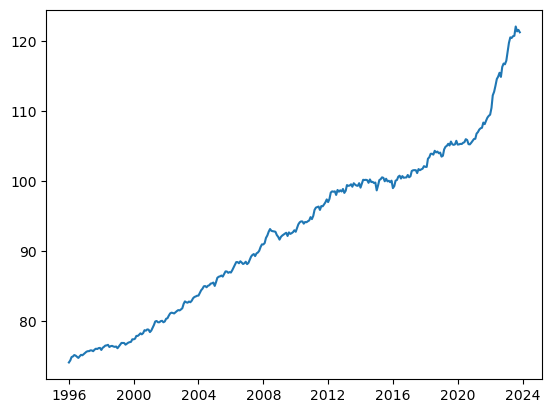

In [115]:
plt.plot(data)

In [98]:
print(HIPC.dataframe)

      TIME 1996-01 1996-02 1996-03 1996-04 1996-05 1996-06 1996-07 1996-08  \
16  France   74.13   74.42    74.9   74.99   75.19   75.11   74.94   74.78   

   1996-09  ... 2023-02 2023-03 2023-04 2023-05 2023-06 2023-07 2023-08  \
16   75.02  ...  118.55  119.76  120.55  120.46  120.71  120.77   122.1   

   2023-09 2023-10 2023-11  
16   121.4  121.61  121.27  

[1 rows x 336 columns]


## Régressions fallacieuses
Dans un premier temps, nous allons montrer que régresser des séries temporelles directement sans transformation mène souvent à une régression de mauvaise qualité lorsque l'on s'intéresse aux résiuds de la régression. 
Nous chercherons dans cette première partie à voir le lien entre les prix d'importation de l'énergie et les prix de production.

In [127]:
#On récupère les prix à l'importation de l'énergie via l'API et idem pour l'Indice des Prix de Production total Industrie
energie_prix_import = pp.import1('010535859')
IPP_tot = pp.import1('010535587')

Comme pour toute série temporelle, il est possible de réaliser une décomposition entre tendance, saisonnalité et résidus au moyen de moyennes mobiles de façon à identifier assez rapidement d'ou proviennent les évolutions observées.

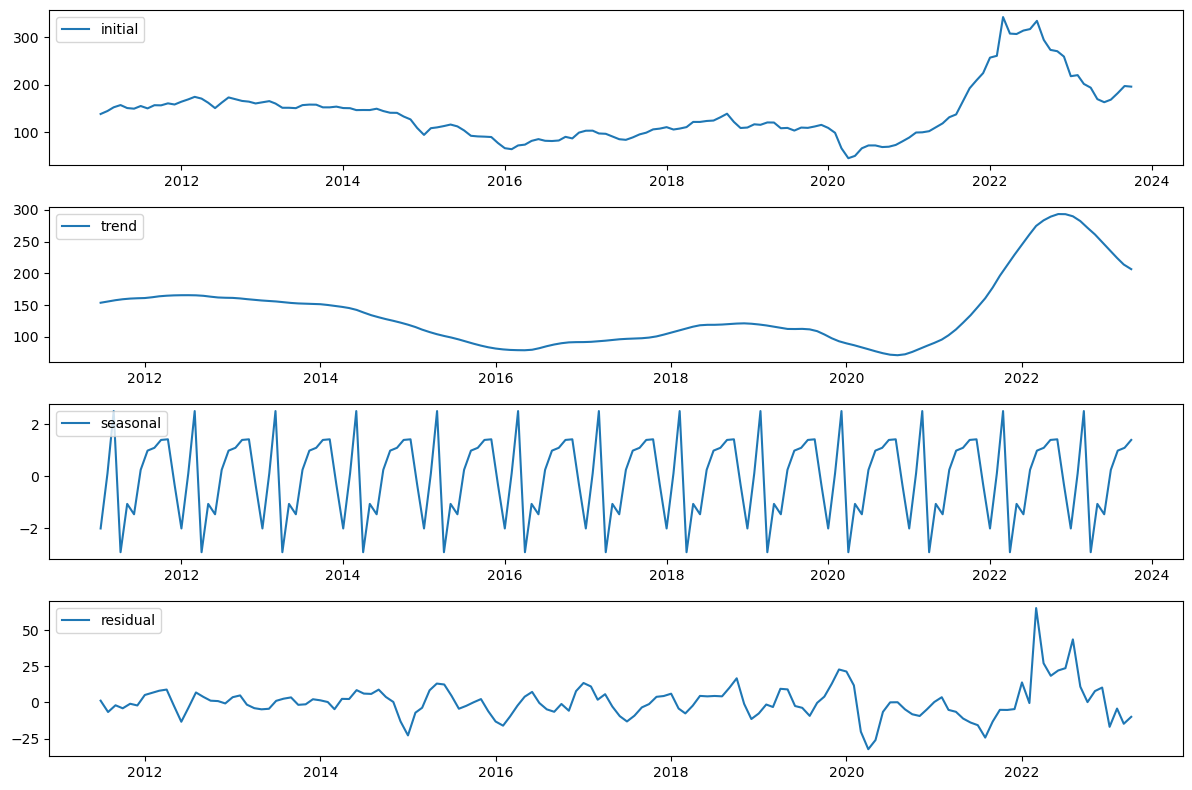

In [128]:
##On supprime toutes les méta-données non utiles pour l'analyse et on passe en index la période pour travailler avec des outils de Séries Temporelles
##Tout d'abord pour la série des prix de l'énergie
result = seasonal_decompose(energie_prix_import,model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid
##Affichage graphique de la décomposition
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(energie_prix_import, label="initial")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label="trend")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label="seasonal")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label="residual")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

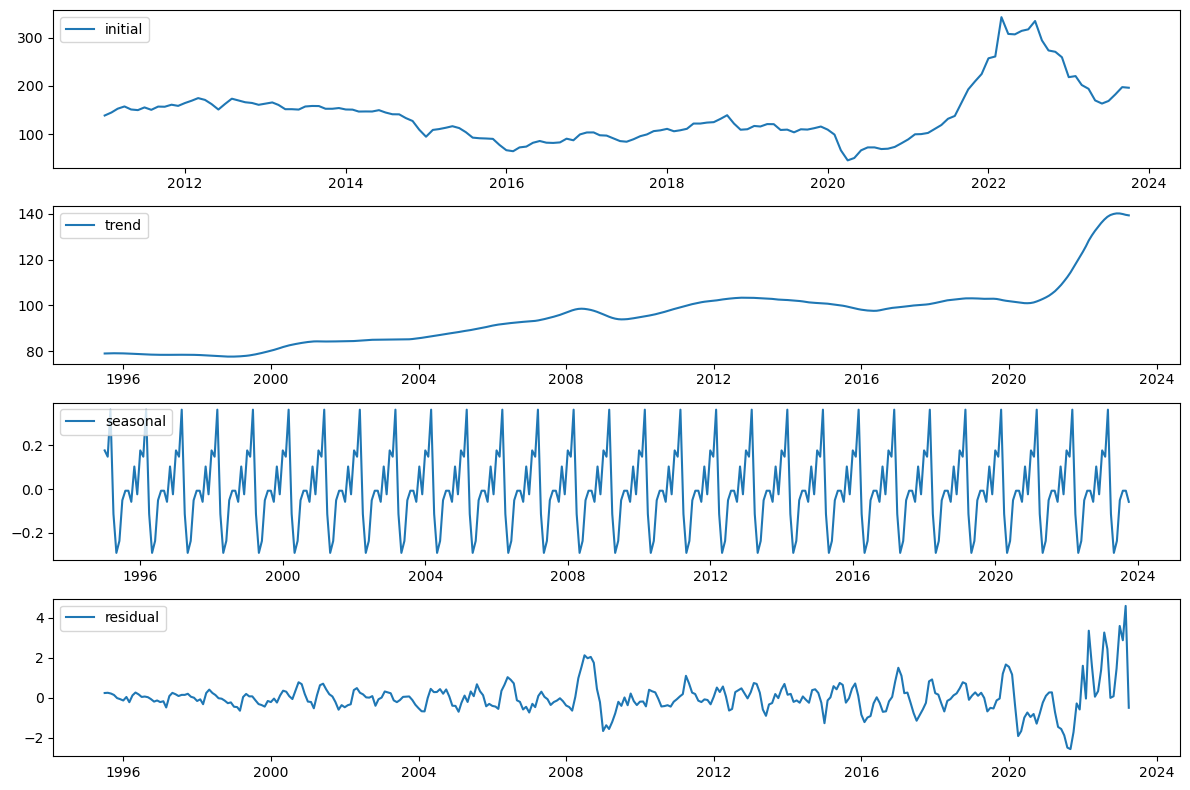

In [129]:
##On transforme également IPP et IPC en séries temporelles IPP
result = seasonal_decompose(IPP_tot,model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid
##Affichage graphique de la décomposition
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(energie_prix_import, label="initial")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label="trend")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label="seasonal")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label="residual")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

On peut déjà observer que le processus résiduel présente des valeurs beaucoup plus importantes aux alentours des crises économiques (2008 et 2019-), l'idée sera que les modèles économétriques seront mis à mal durant les temps de crise et on verra qu'introduire une modélisation avec une équation de long terme et une équation de court terme prenant compte de l'ajustement vis-à-vis de cette équation de long terme (on parlera de modèles à correction d'erreur), permettra de mieux prendre en compte les effets des crises lorsque l'on cherchera à régresser des séries entre elles.


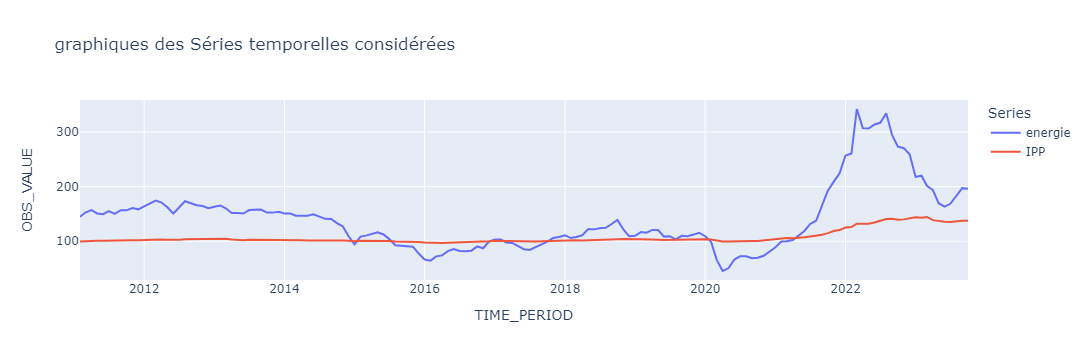

In [130]:
##Visuellement, est-ce qu'on observe un lien entre ces 2 séries?
energie_prix_import["Series"]="energie"
IPP_tot["Series"]="IPP"
data_plot = pd.concat([energie_prix_graph,IPP_graph])
data_plot = data_plot[data_plot.index>"2011-01-31"]
fig = px.line(data_plot, x=data_plot.index, y=pp.f_value, color='Series', title = "graphiques des Séries temporelles considérées", hover_data={pp.f_value:':.2f'})
fig.show()

<Figure size 2500x2500 with 0 Axes>

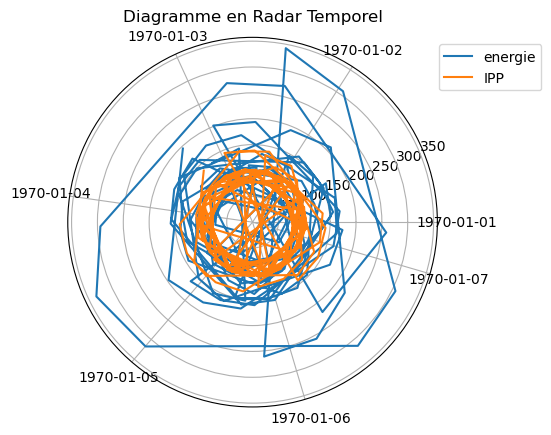

In [131]:
##diagramme en radar temporel
data = pd.merge(energie_prix_import.drop(columns=['Series']),IPP_tot.drop(columns=['Series']), on=pp.f_time, how="inner")
data_sub = data[(data.index>="2015-01-01")]
plt.figure(figsize=(25,25))
fig, ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(data[pp.f_value_x], label='energie')
ax.plot(data[pp.f_value_y], label='IPP')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title('Diagramme en Radar Temporel')
plt.show()
###La très forte volatilité des séries de l'énergie comparé à IPP laisse à penser que la régression ne donnera pas de résultats trop significatifs

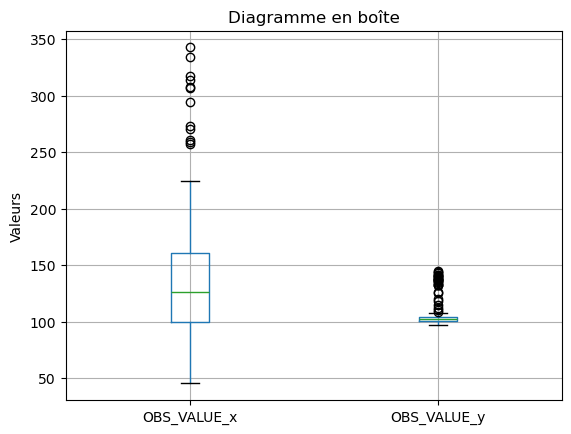

In [132]:
#On peut tirer les mêmes conclusions d'un diagramme en boîte temporel
fig, ax = plt.subplots()
data.boxplot(ax=ax)
ax.set_ylabel('Valeurs')
plt.title('Diagramme en boîte')
plt.show()

#### Notion de non stationnarité
> Une série $X_{t}$ est dite stationnaire si ses deux premiers moments, à savoir son espérance $\mu_{t}$ = E($X_{t}$) et les autocovariances $\gamma_{tk}$ = cov($X_{t}$, $X_{k}$), sont finies et indépendantes du temps.
Visuellement une telle série tend à retourner à sa moyenne quand elle s'en est écartée sous l'effet de chocs.

> La principale forme de non-stationnarité est due à la présence d'une tendance, et là deux cas sont à distinguer :
    - Il peut exister une tendance déterministe dans le processus, qui s'écrit alors sous la forme $X_t = a*t + \epsilon_t$ ; on parle de modèle trend-stationnaire.
    - Ou alors on peut observer une tendance stochastique due à la présence d'une racine unitaire, par exemple le processus $X_t = X_{t-1} + \epsilon_t$.
La différence principale entre ces deux types de tendances réside dans la persistance des chocs. Pour les trend-stationnaires, les chocs s'estompent (forme de retour à la moyenne) alors que pour les racines unitaires les chocs sont permanents et il est donc impossible de proposer des prévisions fiables.

> Il est important de souligner que les techniques générales d'inférence statistique ne fonctionnent plus de façon usuelle quand les séries considérées sont non-stationnaires. En particulier l'estimateur des coefficients est super-convergent (vitesse de convergence en 1/T au lieu de l'habituelle $\sqrt{T}$, de plus on n'a plus l'habituelle convergence de l'écart entre l'estimateur et la vraie valeur vers une loi normale). De ce fait, les tests usuels de Student ne sont plus valides puisque ce n'est plus la même loi asymptotique. On ne peut régresser une série non stationnaire sur une autre série non stationnaire que s'il existe une combinaison linéaire des deux séries qui, elle, est stationnaire (on dit alors que les séries sont co-intégrées).

Afin de stationnariser les séries, on peut travailler avec les différences du premier ordre des séries.

In [133]:
##Test de stationnarité des séries temporelles
energy_adf = adfuller(energie_prix_import.drop(columns=['Series']))
print('p-value',energy_adf[1])
IPP_tot_adf = adfuller(IPP_tot.drop(columns=['Series']))
print('p-value',IPP_tot_adf[1])
##On ne peut nulle part rejeter l'hypothèse nulle de non stationnarité, il faudra donc différencier les séries avant de faire les régressions

p-value 0.5940022688622959
p-value 0.9965016782275393


In [134]:
###Montrons les défauts de passer par une simple régression OLS
data = pd.merge(energie_prix_import.drop(columns=['Series']),IPP_tot.drop(columns=['Series']), on=pp.f_time, how="inner")
##Simple régression OLS
X = sm.add_constant(data[[pp.f_value_x]])
y = data[pp.f_value_y]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
##Comme la variable endogène n'est pas présente avec retard, on peut tester l'autocorrélation des résidus directement avec le test de Durbin-Watson
##le summary nous donne une valeur de 0.049, or pour que les résidus ne soient pas auto-corrélés à l'ordre 1, DW doit être proche de 2 (en pratique
##on accepte des modèle avec DW entre 1.5 et 2.5
##pour afficher directement la stat DW : 
from statsmodels.stats.stattools import durbin_watson
DW_stat = durbin_watson(results.resid)
print("La statistique de test de Durbin Watson a pour valeur : ",DW_stat)
##test d'homoscédasticité des résidus par le test de White
from statsmodels.stats.diagnostic import het_white
white_test = het_white(results.resid,X)
print("p-valeur du test de White : ",white_test[1])
##On rejette l'hypothèse d'homoscédasticité des résidus (p-valeur < 5%)
##Test de normalité des résidus (test de Jarque-Bera)
from scipy.stats import jarque_bera
jb_stat, p_value_JB = jarque_bera(results.resid)
print("p-valeur du test de Jarque-Bera : ",p_value_JB)
##On rejette l'hypothèse nulle de normalité des résidus

##Donc une régression simple n'est pas interprétable dans ces conditions
##La procédure de Cochrane-Orcutt peut être utilisée pour corriger de l'autocorrélation des erreurs
##Elle calcule l'autocorrélation empirique des résidus (rho) puis crée les variables Yt-rhoY(t-1) et idem pour Xt et 
##calcule l'autocrrélation des résidus de cette nouvelle régression etc jusqu'à ce qu'on obtienne une autocorrélation nulle
##Assure plus de confiance dans les test de Student et la significativité statistique des coefficients
from statsmodels.tsa.stattools import acf
acf_resid = acf(results.resid)
weights = -acf_resid[1:]
modele_cochrane_orcutt = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':12, 'weights':weights})
print(modele_cochrane_orcutt.summary())

###Ainsi, malgré un R2 très élevé (0.63) et la significativité des coefficients (d'après les tests usuels), la régression est fallacieuse du fait de la non stationnarité des séries, comme peuvent en témoigner les différents tests statistiques réalisés

                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     256.8
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.81e-34
Time:                        10:24:13   Log-Likelihood:                -533.72
No. Observations:                 154   AIC:                             1071.
Df Residuals:                     152   BIC:                             1078.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          83.0396      1.622     51.190      

In [135]:
##Si on travaille avec des séries différenciées
##On différencie les données pour travailler avec des séries stationnaires
data_diff = data.diff().dropna()
energy_adf = adfuller(data_diff[pp.f_value_x])
IPP_adf = adfuller(data_diff[pp.f_value_y])
print('p-value',energy_adf[1])
print('p-value',IPP_adf[1])
##Parfait, les test de stationnarité rejettent l'hypothèse nulle de non stationanrité des séries utilisées (au pire au seuil de 10%)
##On crée les valeurs lag des observations qui serviront de variables au modèle
lag_x = data_diff[pp.f_value_x].shift(1)
lag_y = data_diff[pp.f_value_y].shift(1)
data_diff['lag_x'] = lag_x
data_diff['lag_y'] = lag_y
data_diff = data_diff.dropna()
##Modelisation
X = sm.add_constant(data_diff[['lag_x','lag_y']])
y = data_diff[pp.f_value_y]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

p-value 0.00047347931334817793
p-value 0.06460233430678242
                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     16.83
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           2.56e-07
Time:                        10:24:16   Log-Likelihood:                -223.91
No. Observations:                 152   AIC:                             453.8
Df Residuals:                     149   BIC:                             462.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

## Modélisation ECM (Error Correction Model)
Il est tout de même possible de régresser des séries non stationnaires entre elles, mais uniquement dans un contexte particulier de séries co-intégrées ; autrement dit s'il existe une combinaison linéaire de ces séries non stationnaires donnant lieu à un processus stationnaire. Cette combinaison linéaire correspond à l'équation de long terme du **modèle ECM (Error Correction Model)**. Cette équation sert à définir une relation d'équilibre. Le résidu issu de celle-ci définit donc une distance à l'équilibre. Le modèle ECM repose sur une seconde équation de court terme qui utilise les variables en variation et le résidu retardé de l'équation de long terme. Dans cette seconde équation, les séries considérées sont stationnaires, ce qui évite les problèmes de régression fallacieuse et permet de définir avec le résidu une force de rappel pour ramener le système à la situation d'équilibre. Ainsi, une modélisation ECM permet de capter les phénomènes de rattrapages ayant lieu après de fortes crises/expansions.

Afin de réduire le biais d'estimation propre à l'équation de long terme, on utilise la **méthode d'estimation de Stock et Watson** consistant à introduire des variations avancées et retardées des variables explicatives.
Pour tester l'existence d'une relation de co-intégration, on peut utiliser le test de Johansen basé sur la statistique de la trace, d'hypothèse nulle l'absence de relation de co-intégration, ou le test de co-intégration de Phillips-Ouliaris d'hypothèse nulle la non co-intégration de la matrice des variableées.

L'équation de long terme doit conduire à une relation de co-intégration (combinaison linéaire stationnaire de séries intégrées d'ordre 1), impliquant notamment que les résidus doivent être stationnaires, ce qui va permettre de rendre compte de la qualité du modèle. Concernant l'équation de court terme, il est nécessaire d'obtenir un résidu homoscédastique et non auto-corrélé (bruit blanc) ; l'éventuelle autocorrélation résiduelle de seconde étape a été traitée par la **méthode de Cochrane Orcutt**.


In [136]:
##Modele à Correction d'Erreur
##Equation de long terme
long_terme = sm.OLS(data[pp.f_value_y], sm.add_constant(data[[pp.f_value_x]])).fit()
print(long_terme.summary())
residus = long_terme.resid
##Equation de court terme
residus_lag = pd.Series(residus.shift(1).dropna(), name='residus')
data_courte = pd.merge(data_diff,residus_lag, on=pp.f_time, how="inner")
court_terme = sm.OLS(data_courte[pp.f_value_y], sm.add_constant(data_courte[[pp.f_value_x,'residus']])).fit()
print(court_terme.summary())
##Le coefficient devant residus peut s'interpréter comme une vitesse de convergence, il est bien négatif comme attendu
##Ici il vaut 1,4%, ce qui signifie qu'à chaque mois, la variable y comble 1,4% de l'écart à sa valeur de long terme (attention ici on a peu de variables explicatives)
##En l'absence de chocs consécutifs, il faudrait donc 100/1.4 = 71 mois soit environ 6 ans pour un retour à l'équilibre

##test de la stationnarité du résidu estimé en première étape
res_adf = adfuller(residus)
print('p-value',res_adf[1])
##Problème, on a un résidu non stationnaire bien que les séries régressées soient stationnaires...
##Attention, dans ce contexte de modèle ECM, aucune loi n'est connue pour les estimateurs, il est donc impossible d'interpréter les tests statistiques sur les coefficients

                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     256.8
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.81e-34
Time:                        10:24:19   Log-Likelihood:                -533.72
No. Observations:                 154   AIC:                             1071.
Df Residuals:                     152   BIC:                             1078.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          83.0396      1.622     51.190      

In [137]:
##Pour limiter le biais introduit à la première étape, Stock et Watson propose des dynamic OLS, où on introduit symétriquement des variations avance et retard dans la première étape
data = pd.merge(energie_prix_import,IPP_tot, on=pp.f_time, how="inner")
nombre_retard = 2
for i in range(1,nombre_retard+1):
    data[f'Delta_X_lag_{i}'] = data[pp.f_value_x]-data[pp.f_value_x].shift(i)
    data[f'Delta_X_lead_{i}'] = data[pp.f_value_x]-data[pp.f_value_x].shift(-i)
data = data.dropna()

##Equation de long terme
long_terme = sm.OLS(data[pp.f_value_y], sm.add_constant(data[[pp.f_value_x,'Delta_X_lag_1','Delta_X_lag_2','Delta_X_lead_1','Delta_X_lead_2']])).fit()
print(long_terme.summary())
residus = long_terme.resid
##test de la stationnarité du résidu estimé en première étape
res_adf = adfuller(residus)
print('p-value',res_adf[1])
###Attention, le processus résiduel n'est toujours pas stationnaire, nous ne pouvons donc pas interpréter les coefficients

##Equation de court terme
##Attention il faut un peu transformer le résidu avant de l'introduire dans l'équation de court terme
residus_trans = data[pp.f_value_y]-long_terme.params[pp.f_value_x]*data[pp.f_value_x]-long_terme.params['const']
residus_lag = pd.Series(residus_trans.shift(1).dropna(), name='residus')
data_courte = pd.merge(data_diff,residus_lag, on=pp.f_time, how="inner")
court_terme = sm.OLS(data_courte[pp.f_value_y], sm.add_constant(data_courte[[pp.f_value_x,'residus']])).fit()
print(court_terme.summary())
##On passe de 1,4% à 1,8% pour la force de rappel, pas de grande différence

                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     62.65
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           2.00e-34
Time:                        10:24:21   Log-Likelihood:                -503.16
No. Observations:                 150   AIC:                             1018.
Df Residuals:                     144   BIC:                             1036.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             82.2206      1.522     54.

In [138]:
#####Pourquoi n'obtient-on pas une équation de long terme avec un résidu stationnaire?
##Si on réalise le test de co-intégration pour tester si il existe une relation entre nos 2 séries de façon à obtenir un  résidu stationnaire, le test de Johansen ne permet  pas de 
#rejeter l'hypothèse nulle de non co-intégration, de ce fait on ne pourra pas trouver une relation de long terme pour le modèle ECM
test_coint = coint(data[pp.f_value_x],data[pp.f_value_y])
print("p-valeur du test de co-intégration : ", test_coint[1]) 

p-valeur du test de co-intégration :  0.3443460269505713


## Nouvel exemple 

Dans cette partie nous cherchons à identifier, pour le prix de production des voitures en France, l'impact des variations des p^rix des matières premières les plus utilisées dans la conception automobile. 
Nous partirons sur une modélisation par ECM qui cette fois présentera une équation de long terme avec un résidu stationnaire.
Plus précisément, nous comparerons la régression obtenue juste en stationnarisant les séries (par différence de premier ordre) avec l'équation de court terme d'un modèle ECM (qui de fait introduit une force de rappel), et nous comparerons les contributions des différentes variables.

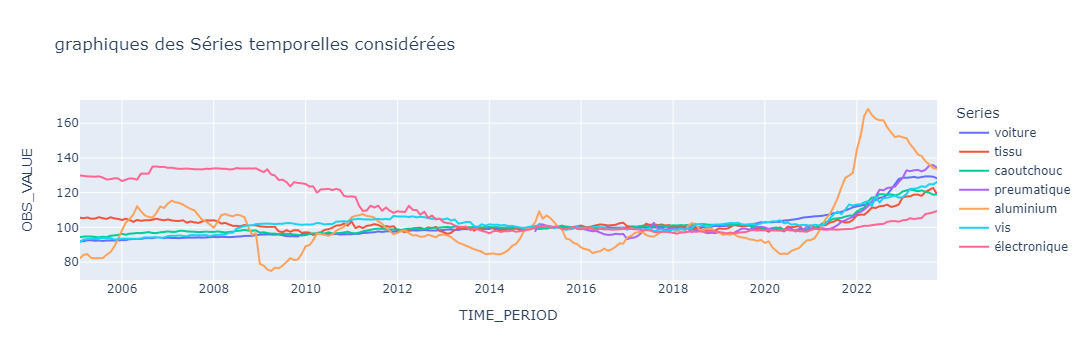

In [139]:
###Importation des nouvelles données
prix_voit = pp.import2('010534366',"voiture")
prix_tissu = pp.import2('010534078',"tissu")
prix_caoutc = pp.import2('010534200',"caoutchouc")
prix_pneum = pp.import2('010534202',"preumatique")
prix_alu = pp.import2('010534272',"aluminium")
prix_vis = pp.import2('010534314',"vis")
prix_electro = pp.import2('010534318',"électronique")

data_plot = pd.concat([prix_voit,prix_tissu,prix_caoutc,prix_pneum,prix_alu,prix_vis,prix_electro])
data_plot = data_plot[data_plot.index>"2005-01-31"]
fig = px.line(data_plot, x=data_plot.index, y='OBS_VALUE', color='Series', title = "graphiques des Séries temporelles considérées", hover_data={'OBS_VALUE':':.2f'})
fig.show()

In [140]:
#Construction de la base
prix_voit = pp.sub_rename(prix_voit,"2005-01-31",'voit')
prix_tissu = pp.sub_rename(prix_tissu,"2005-01-31",'tissu')
prix_caoutc = pp.sub_rename(prix_caoutc,"2005-01-31",'caoutc')
prix_pneum = pp.sub_rename(prix_pneum,"2005-01-31",'pneum')
prix_alu = pp.sub_rename(prix_alu,"2005-01-31",'alu')
prix_vis = pp.sub_rename(prix_vis,"2005-01-31",'vis')
prix_electro = pp.sub_rename(prix_electro,"2005-01-31",'elect')

data = pd.merge(prix_voit['voit'],prix_tissu['tissu'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_caoutc['caoutc'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_pneum['pneum'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_alu['alu'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_vis['vis'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_electro['elect'], on='TIME_PERIOD', how="inner")

<Figure size 2500x2500 with 0 Axes>

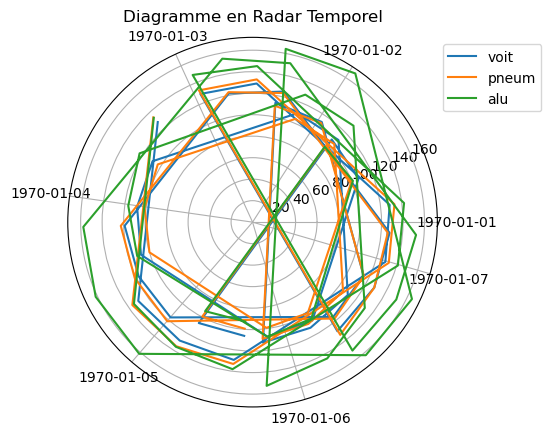

In [141]:
###Quelques outils de data-visualisation
##diagramme en radar temporel
data = pd.merge(prix_voit['voit'],prix_tissu['tissu'], on=pp.f_time, how="inner")
data = pd.merge(data,prix_caoutc['caoutc'], on=pp.f_time, how="inner")
data = pd.merge(data,prix_pneum['pneum'], on=pp.f_time, how="inner")
data = pd.merge(data,prix_alu['alu'], on=pp.f_time, how="inner")
data = pd.merge(data,prix_vis['vis'], on=pp.f_time, how="inner")
data = pd.merge(data,prix_electro['elect'], on=pp.f_time, how="inner")
data_sub = data[(data.index>="2021-01-01")]
plt.figure(figsize=(25,25))
fig, ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(data_sub['voit'], label='voit')
ax.plot(data_sub['pneum'], label='pneum')
ax.plot(data_sub['alu'], label='alu')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title('Diagramme en Radar Temporel')
plt.show()

###On observe un fort lien entre ces 3 variables, ce qui va venir renforcer l'idée d'existence d'une relation de co-intégration entre nos variables

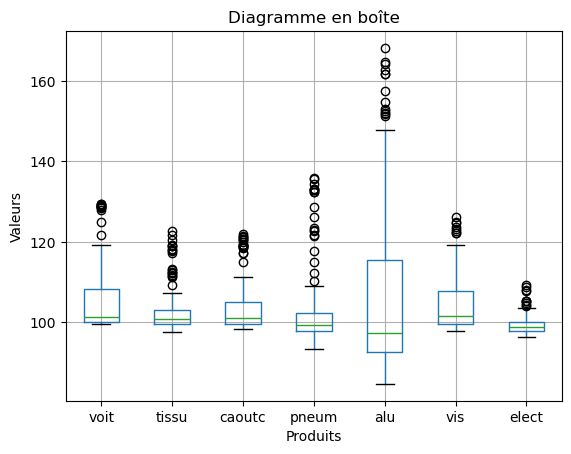

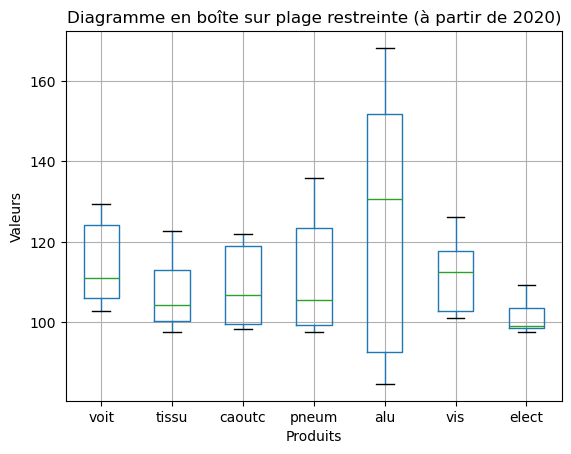

In [142]:
#diagramme en boîte temporel
fig, ax = plt.subplots()
data.boxplot(ax=ax)
ax.set_xlabel('Produits')
ax.set_ylabel('Valeurs')
plt.title('Diagramme en boîte')
plt.show()

##Sur plage temporelle plus restreinte
data_sub = data[(data.index>="2020-01-01")]
fig, ax = plt.subplots()
data_sub.boxplot(ax=ax)
ax.set_xlabel('Produits')
ax.set_ylabel('Valeurs')
plt.title('Diagramme en boîte sur plage restreinte (à partir de 2020)')
plt.show()

p-value  voit   0.005479583355177443
p-value  tissu   0.8247711051732571
p-value  caoutc   0.01539240273249019
p-value  pneum   3.5554034068261476e-05
p-value  alu   0.06285176739552743
p-value  vis   0.046265225564928195
p-value  elect   0.1138091991385361
                            OLS Regression Results                            
Dep. Variable:                   voit   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.342
Date:                Tue, 12 Dec 2023   Prob (F-statistic):             0.0372
Time:                        10:24:35   Log-Likelihood:                -85.268
No. Observations:                 105   AIC:                             184.5
Df Residuals:                      98   BIC:                             203.1
Df Model:                           6                                         
Covariance Type:            non

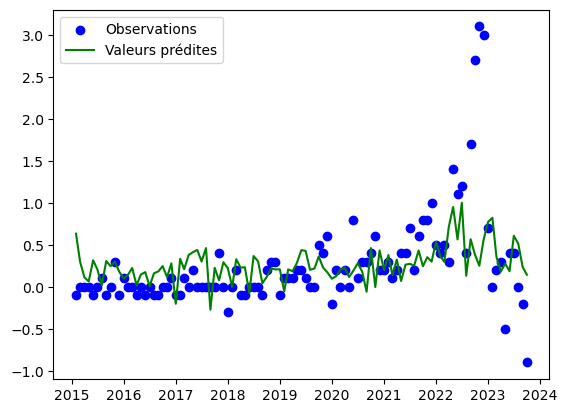

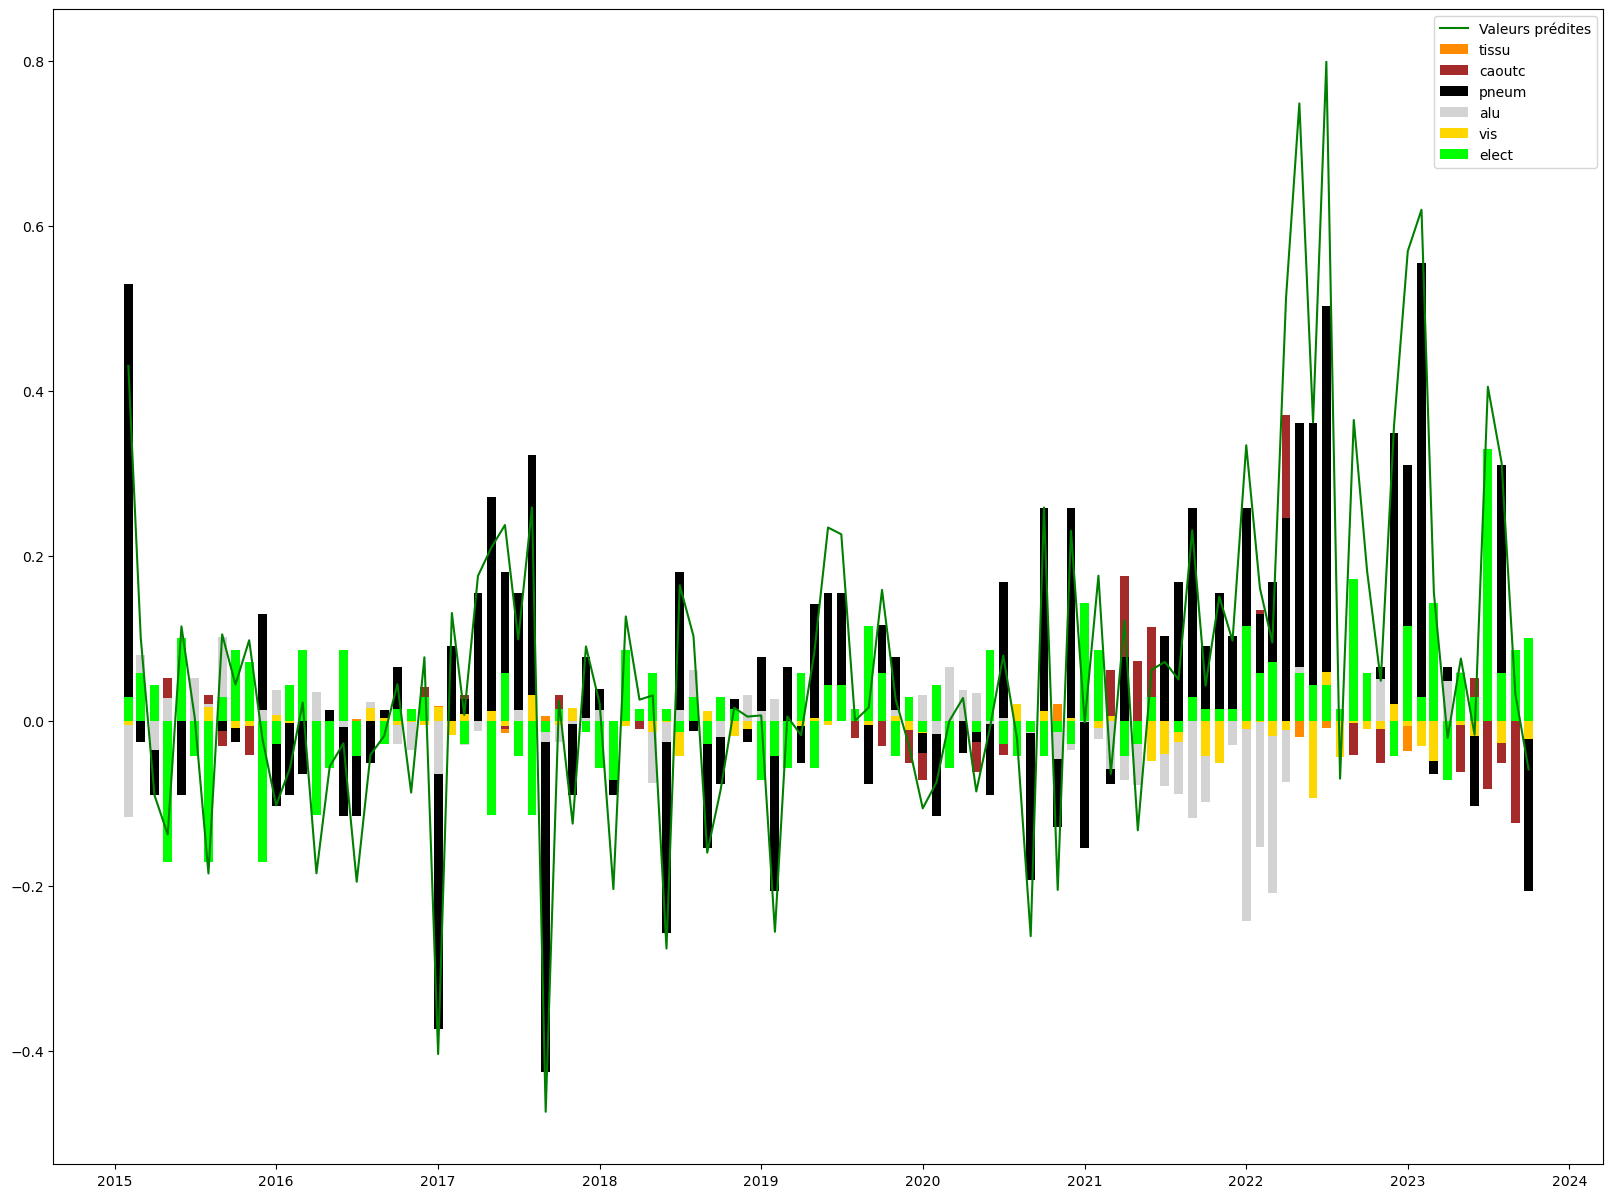

In [143]:
###Simple regression sur les variables différenciées
##On vérifie d'abord la stationnarité de ces nouvelles variables

##On différencie les données pour travailler avec des séries stationnaires
data_diff = data.diff().dropna()
##On vérifie la stationnarité des séries utilisées
for i in ['voit','tissu','caoutc','pneum','alu','vis','elect'] :
    test_adf = adfuller(data_diff[i])
    print('p-value ', i,' ', test_adf[1])
##Seul le test de stationnarité sur le tissu est dangereux pour notre analyse, les autres variables donnent des résultats acceptables


X = sm.add_constant(data_diff[['tissu','caoutc','pneum','alu','vis','elect']])
y = data_diff['voit']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

##Outil de visualisation
contributions = X * results.params
y_pred = results.predict(X)
import matplotlib.pyplot as plt
plt.scatter(X.index,y, label="Observations", color="blue")
plt.plot(X.index, y_pred, label = "Valeurs prédites", color = "green")
plt.legend()
plt.show()


plt.figure(figsize=(20,15))
plt.bar(X.index,contributions['tissu'], label = "tissu", color="darkorange",width=20)
plt.bar(X.index,contributions['caoutc'], label = "caoutc", color="brown",width=20)
plt.bar(X.index,contributions['pneum'], label = "pneum", color="black",width=20)
plt.bar(X.index,contributions['alu'], label = "alu", color="lightgray",width=20)
plt.bar(X.index,contributions['vis'], label = "vis", color="gold",width=20)
plt.bar(X.index,contributions['elect'], label = "elect", color="lime",width=20)
plt.plot(X.index, y_pred-contributions['const'], label = "Valeurs prédites", color = "green")
plt.legend()
plt.show()

In [144]:
###Peut-on avoir des ruptures dans les relations?
data1 = data_diff[data_diff.index<="2020-01-31"]
X1 = sm.add_constant(data1[['tissu','caoutc','pneum','alu','vis','elect']])
y1 = data1['voit']
data2 = data_diff[data_diff.index>"2020-01-31"]
X2 = sm.add_constant(data2[['tissu','caoutc','pneum','alu','vis','elect']])
y2 = data2['voit']
model1 = sm.OLS(y1, X1)
results1 = model1.fit()
print(results1.summary())
model2 = sm.OLS(y2, X2)
results2 = model2.fit()
print(results2.summary())
##On observe une très forte variabilité des coefficients

                            OLS Regression Results                            
Dep. Variable:                   voit   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.9154
Date:                Tue, 12 Dec 2023   Prob (F-statistic):              0.491
Time:                        10:24:39   Log-Likelihood:                 26.022
No. Observations:                  60   AIC:                            -38.04
Df Residuals:                      53   BIC:                            -23.38
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0430      0.022      1.965      0.0

                            OLS Regression Results                            
Dep. Variable:                   voit   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     253.2
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           4.56e-61
Time:                        10:24:41   Log-Likelihood:                -129.04
No. Observations:                 102   AIC:                             320.1
Df Residuals:                      71   BIC:                             401.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -47.0639    

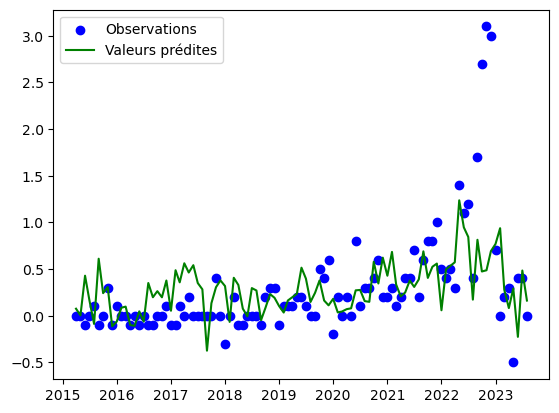

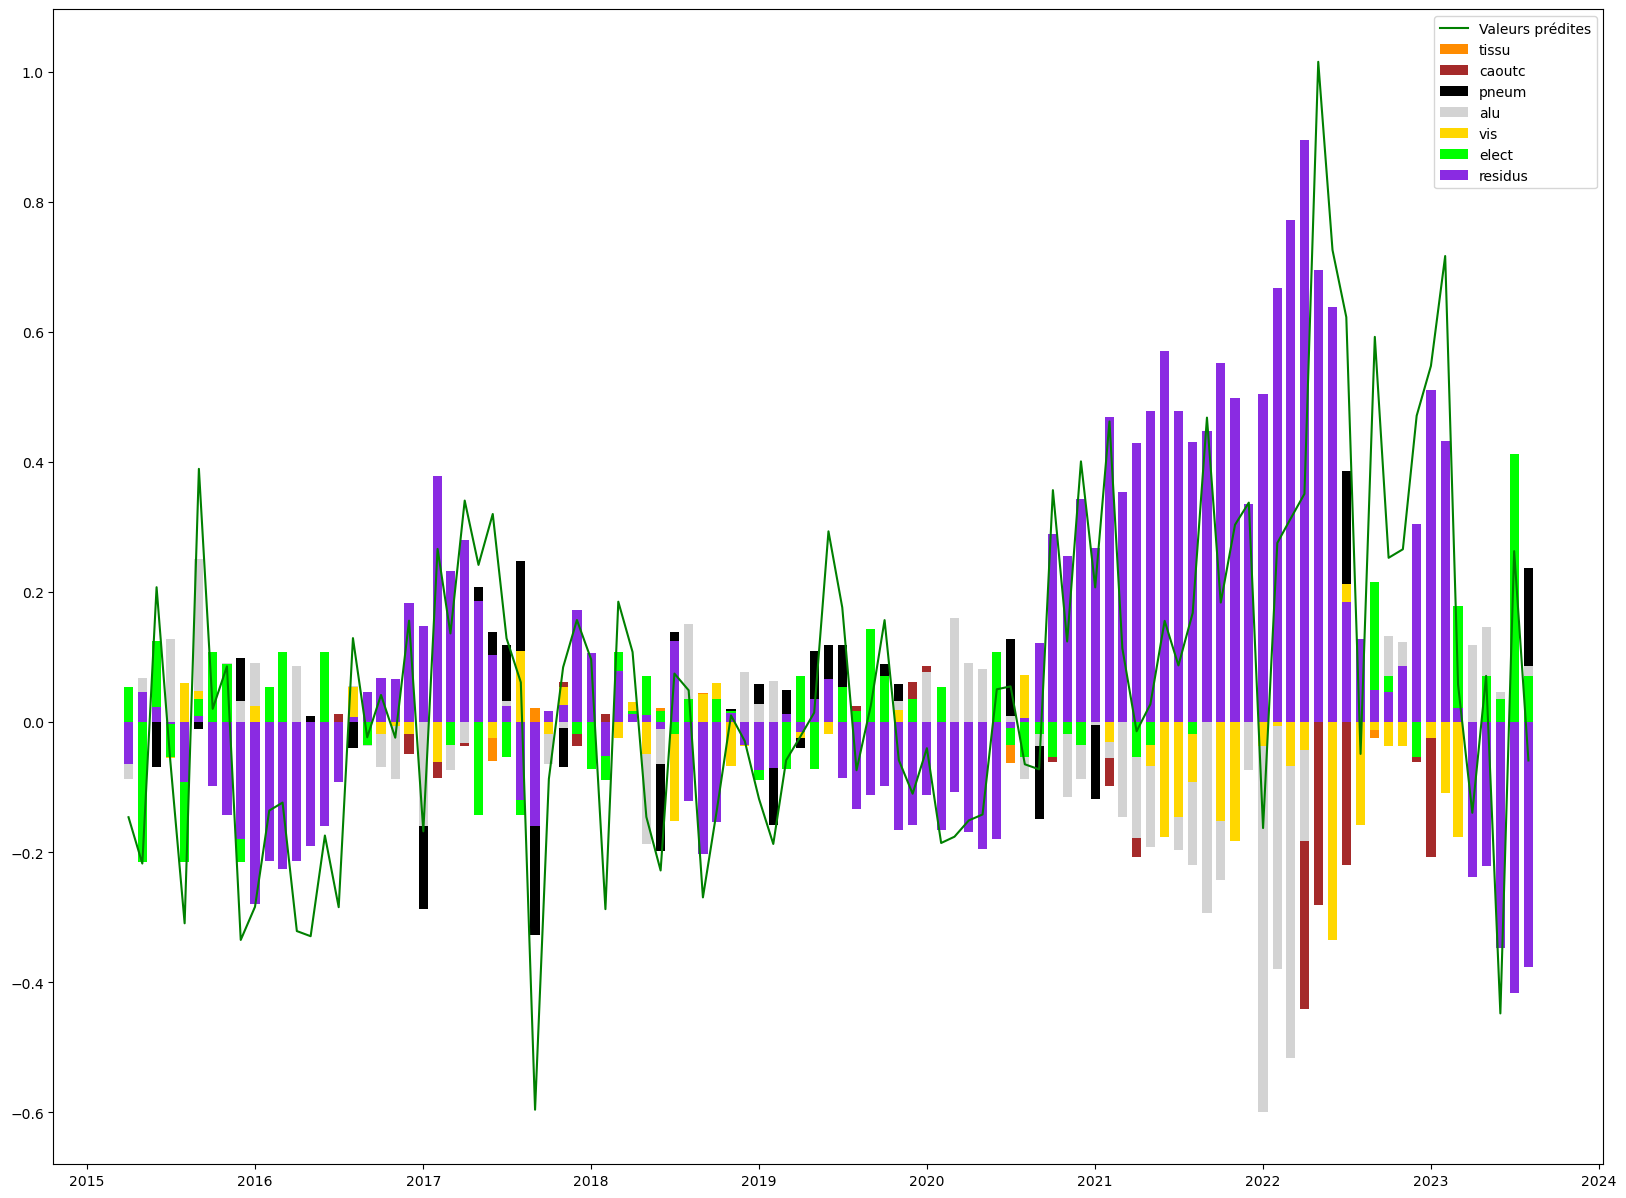

In [145]:
##On peut dès lors voir l'intérêt d'introduire la force de rappel issu d'une équation de long terme, particulièrement adaptée pour modéliser les chocs dus aux crises
##On va donc dans un premier temps rechercher une équation de long terme
##Pour rappel, on doit obtenir un résidu stationnaire à l'issu de cette première étape
##Dans un premier temps on essaie directement la méthode de Stock et Watson
##Pour limiter le biais introduit à la première étape, Stock et Watson propose des dynamic OLS, où on introduit symétriquement des variations avance et retard dans la première étape
data_SW = data
nombre_retard = 2
for j in ['tissu','caoutc','pneum','alu','vis','elect']:
    for i in range(1,nombre_retard+1):
        data_SW[f'Delta_{j}_lag_{i}'] = data_SW[f'{j}']-data_SW[f'{j}'].shift(i)
        data_SW[f'Delta_{j}_lead_{i}'] = data_SW[f'{j}']-data_SW[f'{j}'].shift(-i)
data_SW = data_SW.dropna()
X_SW = data_SW.drop(columns=['voit'])
##Equation de long terme
long_terme = sm.OLS(data_SW['voit'], sm.add_constant(X_SW)).fit()
print(long_terme.summary())
residus = long_terme.resid
##test de la stationnarité du résidu estimé en première étape
res_adf = adfuller(residus)
print('p-value',res_adf[1])
##Parfait, le résidu est stationnaire

##Equation de court terme
##Attention il faut un peu transformer le résidu avant de l'introduire dans l'équation de court terme
residus_trans = data_SW['voit']-np.sum(long_terme.params[['tissu','caoutc','pneum','alu','vis','elect']]*data_SW[['tissu','caoutc','pneum','alu','vis','elect']], axis=1)-long_terme.params['const']
residus_lag = pd.Series(residus_trans.shift(1).dropna(), name='residus')
data_courte = pd.merge(data_diff,residus_lag, on=pp.f_time, how="inner")
X = sm.add_constant(data_courte[['tissu','caoutc','pneum','alu','vis','elect','residus']])
y = data_courte['voit']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
##On observe tout de même une amélioration du R2 ajusté

##Outil de visualisation
contributions = X * results.params
y_pred = results.predict(X)
import matplotlib.pyplot as plt
plt.scatter(X.index,y, label="Observations", color="blue")
plt.plot(X.index, y_pred, label = "Valeurs prédites", color = "green")
plt.legend()
plt.show()

plt.figure(figsize=(20,15))
plt.bar(X.index,contributions['tissu'], label = "tissu", color="darkorange",width=20)
plt.bar(X.index,contributions['caoutc'], label = "caoutc", color="brown",width=20)
plt.bar(X.index,contributions['pneum'], label = "pneum", color="black",width=20)
plt.bar(X.index,contributions['alu'], label = "alu", color="lightgray",width=20)
plt.bar(X.index,contributions['vis'], label = "vis", color="gold",width=20)
plt.bar(X.index,contributions['elect'], label = "elect", color="lime",width=20)
plt.bar(X.index,contributions['residus'], label = "residus", color="blueviolet",width=20)
plt.plot(X.index, y_pred-contributions['const'], label = "Valeurs prédites", color = "green")
plt.legend()
plt.show()